<center><h1>Decision tree 970 days </h1></center>

In [ ]:
#Importing the Libraries
!pip install -q pycaret
!pip install -q bt
!pip uninstall -q xgboost -y
!pip install -q xgboost==1.2.0

## Loading and Installing Libraries

In [2]:
from pathlib import Path
import pycaret

import csv
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
import xgboost as xgb
from datetime import datetime
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, roc_auc_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.model_selection import TimeSeriesSplit as TimeBasedCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import time
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from statistics import mean
import statsmodels.api as sm
from statsmodels import regression
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

import lightgbm
import matplotlib
from matplotlib import pyplot as plt
from numpy import loadtxt

import types
from sklearn.decomposition import PCA
import joblib
import re

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data preprocess function

In [3]:
def vol_generation(pd_input):
    Volatility3 = (pd_input.rolling(window=3).std() * np.sqrt(252 / 3)) / 10
    Volatility5 = (pd_input.rolling(window=5).std() * np.sqrt(252 / 5)) / 10
    Volatility22 = (pd_input.rolling(window=22).std() * np.sqrt(252 / 22)) / 10
    Volatility3 = Volatility3.astype(float)
    Volatility5 = Volatility5.astype(float)
    Volatility22 = Volatility22.astype(float)
    Vol_Ratio = Volatility5/Volatility22
    
    return Volatility3, Volatility5, Volatility22, Vol_Ratio

def return_diff(X,cols):
    df1 = X.copy()
    for c in cols:
        df1[c] = pd.to_numeric(df1[c],errors='coerce')
    for c in cols:
        name = str(c)+"_RD"
        df1[name] = df1[c] - df1['Index_Close']
    return df1

#Data preprocessing function

def data_preprocess(X):
    df = X.copy()
    df['Date'] = pd.to_datetime(df['Date'],errors='coerce')
    df['day_of_week'] = df['Date'].dt.day_name()
    df['day_of_week'].replace({'Monday':0,'Tuesday':1,'Wednesday':3,'Thursday':3,'Friday':4},inplace=True)
    data_10_19 = df.copy()
    data_10_19 = data_10_19[data_10_19["Index_High"].notna()].copy()
    data_10_19.set_index("Date",inplace=True)

    df_cols = ['AIV.N', 'AMZN.OQ', 'APD.N', 'BBY.N', 'BIIB.OQ', 'BRKb.N', 'C.N','CAT.N', 'CBOE.Z', 
           'CHD.N', 'CINF.OQ', 'DIS.N', 'DLTR.OQ', 'EFX.N','EVRG.N', 'FMC.N', 'HSIC.OQ','HGc1' ,
           'IVZ.N', 'KMI.N', 'LLY.N', 'MMM.N', 'MOS.N', 'MRK.N', 'PEAK.N', 'PEP.OQ', 'RHI.N', 'SRE.N', 
           'SYK.N','TRV.N', 'UNH.N', 'UPS.N','Index_Close','day_of_week']

    for cl in df_cols: data_10_19[cl] = pd.to_numeric(data_10_19[cl],errors='coerce')

    data = data_10_19[df_cols].copy()

    for c in df_cols: data[c] = pd.to_numeric(data[c],errors='coerce')

    tar_col = "Index_Close"
    # Evaluating the 3,5 and 22 day SP500 Returns
    Returns3 = data[tar_col].pct_change(periods=3)
    Returns5 = data[tar_col].pct_change(periods=5)
    Returns22 = data[tar_col].pct_change(periods=22)

    pct_cols = ['AIV.N', 'AMZN.OQ', 'APD.N', 'BBY.N', 'BIIB.OQ', 'BRKb.N', 'C.N','CAT.N', 'CBOE.Z', 
           'CHD.N', 'CINF.OQ', 'DIS.N', 'DLTR.OQ', 'EFX.N','EVRG.N', 'FMC.N', 'HSIC.OQ','HGc1' ,
           'IVZ.N', 'KMI.N', 'LLY.N', 'MMM.N', 'MOS.N', 'MRK.N', 'PEAK.N', 'PEP.OQ', 'RHI.N', 'SRE.N', 
           'SYK.N','TRV.N', 'UNH.N', 'UPS.N','Index_Close']

    # Pre-Processing Data
    data[pct_cols] = data[pct_cols].pct_change()
    #Adding trending variable
    tr_col = data['Index_Close'].values
    trends = [0,0]
    prev_val = tr_col[1]
    for idx in range(2,len(tr_col)):
        if tr_col[idx]>0 and prev_val>0:
            trends.append(trends[idx-1]+1)
        elif tr_col[idx]<0 and prev_val<0:
            trends.append(trends[idx-1]-1)
        else:
            trends.append(0) 

    rd_cols =  ['AIV.N', 'AMZN.OQ', 'APD.N', 'BBY.N', 'BIIB.OQ', 'BRKb.N', 'C.N','CAT.N', 'CBOE.Z', 
           'CHD.N', 'CINF.OQ', 'DIS.N', 'DLTR.OQ', 'EFX.N','EVRG.N', 'FMC.N', 'HSIC.OQ','HGc1' ,
           'IVZ.N', 'KMI.N', 'LLY.N', 'MMM.N', 'MOS.N', 'MRK.N', 'PEAK.N', 'PEP.OQ', 'RHI.N', 'SRE.N', 
           'SYK.N','TRV.N', 'UNH.N', 'UPS.N']
    # Adding return differential
    data = return_diff(data,rd_cols)
    a = pd.DataFrame()
    a["log_ret"] = data["Index_Close"].pct_change()
    #Adding volatility
    data["Volatility3"], data["Volatility5"], data["Volatility22"], data["Vol_Ratio"] = vol_generation(a["log_ret"])
    #Adding consecutive trend and commulative trend
    # How many consecutive days index is up or down
    data['symbol'] = data['Index_Close'].apply(lambda x : 1 if x>0 else -1)
    sym = data['symbol'].values

    consctv = [0,0]
    for i in range(2,len(sym)):
        ans = sym[i] if sym[i-1]==sym[i] else 0
        consctv.append(ans)
    data['consecutive'] = consctv

    comm_cons = [0,0,0]
    for j in range(3,len(consctv)):
        if consctv[j]>0 or consctv[j]<0:
            cs = 0
            for s in range(j,2,-1):
                if consctv[s]!=0:
                    cs+=consctv[s]
                else:
                    break
        comm_cons.append(cs)
        cs = 0

    data['comm_cons'] = comm_cons
    #Shift target 1 up
    data = data.fillna(axis=1, method="ffill")
    data[tar_col] = data[tar_col].shift(-1)
    #Adding target and big moves
    data["Target"] = np.array([1 if x>0 else 0 for x in data[tar_col]])

    data["big_moves"] = pd.DataFrame(data[tar_col].apply(lambda x: abs(x)) > 0.8 * data[tar_col].std()).astype(int)
    data["big_moves_pos"] = pd.DataFrame(data[tar_col] > 0.8 * data[tar_col].std()).astype(int)
    data["big_moves_neg"] = pd.DataFrame(data[tar_col] < - 0.8 * data[tar_col].std()).astype(int)
    #adding returns  to data
    data["Returns3"] = Returns3
    data["Returns5"] = Returns5
    data["Returns22"] = Returns22
    #Adding volatility ratio trend
    #it kind of pseudo feature to detect some big events happening in the market
    data["Vol_Ratio_Trend"] = data["Vol_Ratio"] * data["Returns3"].apply(lambda x: np.sign(x))
    #Adding volatility to dataframe
    data["Volatility3"] = data["Volatility3"].astype(float)
    data["Volatility5"] = data["Volatility5"].astype(float)
    data["Volatility22"] = data["Volatility22"].astype(float)
    data["Vol_Ratio"] = data["Vol_Ratio"].astype(float)
    data["Vol_Ratio_Trend"] = data["Vol_Ratio_Trend"].astype(float)
    # Set Binary Parameters for the Target Variable
    data.drop(data.tail(1).index, inplace=True) # Becasue we are shifting SPX by one up
    data.drop(data.head(3).index, inplace=True) # because we are calculating 3 days returns of SPX 
    data = data.fillna(axis=1, method="ffill")
    #Adding if day is friday
    data["Friday"] = data["day_of_week"] == 4
    data["Friday"] = data["Friday"].astype(int)
    start = data.index.searchsorted(datetime(2010, 1, 8))
    data = data.iloc[start:].copy()
    data_chk = data.copy() #creating a copy for saving
    fin_cols = ['AIV.N', 'AMZN.OQ', 'APD.N', 'BBY.N', 'BIIB.OQ', 'BRKb.N', 'C.N',
                'CAT.N', 'CBOE.Z', 'CHD.N', 'CINF.OQ', 'DIS.N', 'DLTR.OQ', 'EFX.N',
                'EVRG.N', 'FMC.N', 'HSIC.OQ', 'HGc1', 'IVZ.N', 'KMI.N', 'LLY.N',
                'MMM.N', 'MOS.N', 'MRK.N', 'PEAK.N', 'PEP.OQ', 'RHI.N', 'SRE.N',
                'SYK.N', 'TRV.N', 'UNH.N', 'UPS.N', 'Index_Close', 'day_of_week', 'AIV.N_RD', 'AMZN.OQ_RD', 'APD.N_RD', 'BBY.N_RD',
                'BIIB.OQ_RD', 'BRKb.N_RD', 'C.N_RD', 'CAT.N_RD', 'CBOE.Z_RD',
                'CHD.N_RD', 'CINF.OQ_RD', 'DIS.N_RD', 'DLTR.OQ_RD', 'EFX.N_RD',
                'EVRG.N_RD', 'FMC.N_RD', 'HSIC.OQ_RD', 'HGc1_RD', 'IVZ.N_RD',
                'KMI.N_RD', 'LLY.N_RD', 'MMM.N_RD', 'MOS.N_RD', 'MRK.N_RD', 'PEAK.N_RD',
                'PEP.OQ_RD', 'RHI.N_RD', 'SRE.N_RD', 'SYK.N_RD', 'TRV.N_RD', 'UNH.N_RD',
                'UPS.N_RD','Returns3', 'Returns5', 'Returns22','Target','symbol', 'consecutive','comm_cons', "Volatility3",
                "Volatility5","Volatility22","Vol_Ratio", "Friday", "Vol_Ratio_Trend"]
    #Converting features to numeric values   
    for c in fin_cols: data[c] = pd.to_numeric(data[c],errors='coerce');
    
    X = data.copy()
    y = data["Target"].copy()

    X.drop(["Target"], inplace=True, axis=1)
    X.drop([tar_col], inplace=True, axis=1)

    return X, y,data

## Loading and processing data

In [4]:
df = pd.read_csv('refinitivData_20201110.csv')
df.drop(df.head(2).index, inplace = True )
rename_dict = {'Instrument':'Date',".SPX":"Index_High",".SPX.1":"Index_Close",".SPX.2":"Index_Low",".SPX.3":"Index_Open",
               "ISPCS00":"ISPC_High","ISPCS00.1":"ISPC_Low","ISPCS00.2":"ISPC_Open","ISPCS00.3":"ISPC_Close"}
df.rename(columns=rename_dict,inplace=True)

X,y,data = data_preprocess(df)

from tqdm.notebook import tqdm
d = X
d['tclass']= y
top_features_M1 = ['AIV.N', 'AMZN.OQ', 'APD.N', 'BBY.N', 'BIIB.OQ', 'BRKb.N', 'C.N', 'CAT.N', 'CBOE.Z', 
                    'CHD.N', 'CINF.OQ', 'HGc1', 'DIS.N', 'DLTR.OQ', 'EFX.N', 'EVRG.N', 'FMC.N', 'HSIC.OQ', 
                    'IVZ.N', 'KMI.N', 'LLY.N', 'MMM.N', 'MOS.N', 'MRK.N', 'PEAK.N', 'PEP.OQ', 'RHI.N', 'Returns3', 'SRE.N', 
                    'SYK.N', 'TRV.N', 'UNH.N', 'UPS.N','tclass']
d.loc[:,top_features_M1]
mydf = d.loc[:,top_features_M1]
mydf.to_csv("mydf.csv")

In [5]:
data.columns

Index(['AIV.N', 'AMZN.OQ', 'APD.N', 'BBY.N', 'BIIB.OQ', 'BRKb.N', 'C.N',
       'CAT.N', 'CBOE.Z', 'CHD.N', 'CINF.OQ', 'DIS.N', 'DLTR.OQ', 'EFX.N',
       'EVRG.N', 'FMC.N', 'HSIC.OQ', 'HGc1', 'IVZ.N', 'KMI.N', 'LLY.N',
       'MMM.N', 'MOS.N', 'MRK.N', 'PEAK.N', 'PEP.OQ', 'RHI.N', 'SRE.N',
       'SYK.N', 'TRV.N', 'UNH.N', 'UPS.N', 'Index_Close', 'day_of_week',
       'AIV.N_RD', 'AMZN.OQ_RD', 'APD.N_RD', 'BBY.N_RD', 'BIIB.OQ_RD',
       'BRKb.N_RD', 'C.N_RD', 'CAT.N_RD', 'CBOE.Z_RD', 'CHD.N_RD',
       'CINF.OQ_RD', 'DIS.N_RD', 'DLTR.OQ_RD', 'EFX.N_RD', 'EVRG.N_RD',
       'FMC.N_RD', 'HSIC.OQ_RD', 'HGc1_RD', 'IVZ.N_RD', 'KMI.N_RD', 'LLY.N_RD',
       'MMM.N_RD', 'MOS.N_RD', 'MRK.N_RD', 'PEAK.N_RD', 'PEP.OQ_RD',
       'RHI.N_RD', 'SRE.N_RD', 'SYK.N_RD', 'TRV.N_RD', 'UNH.N_RD', 'UPS.N_RD',
       'Volatility3', 'Volatility5', 'Volatility22', 'Vol_Ratio', 'symbol',
       'consecutive', 'comm_cons', 'Target', 'big_moves', 'big_moves_pos',
       'big_moves_neg', 'Returns3', 'Returns5'

In [6]:
import pandas as pd

In [7]:
start = mydf.index.searchsorted(datetime(2010, 1, 8))
end = mydf.index.searchsorted(datetime(2020, 11, 9))
mydf = mydf.iloc[start:end+1]
mydf

,AIV.N,AMZN.OQ,APD.N,BBY.N,BIIB.OQ,BRKb.N,C.N,CAT.N,CBOE.Z,CHD.N,CINF.OQ,HGc1,DIS.N,DLTR.OQ,EFX.N,EVRG.N,FMC.N,HSIC.OQ,IVZ.N,KMI.N,LLY.N,MMM.N,MOS.N,MRK.N,PEAK.N,PEP.OQ,RHI.N,Returns3,SRE.N,SYK.N,TRV.N,UNH.N,UPS.N,tclass
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-08,-0.023177,0.027077,0.006395,-0.039239,0.020568,-0.000286,-0.016438,0.011228,0.011228,-0.002162,-0.003375,-0.004676,0.001571,-0.013795,0.000313,0.008825,-0.008852,0.005964,-0.005640,-0.005640,-0.007655,0.007046,0.014294,-0.000530,0.006619,-0.003280,-0.000684,0.007444,-0.000557,0.003077,-0.001439,-0.009391,0.048075,1.0
2010-01-11,0.007717,-0.024056,0.018328,-0.017038,-0.003326,0.000900,0.011142,0.062811,0.062811,-0.004334,0.007524,0.008662,-0.016311,-0.005473,-0.009393,0.015193,-0.027338,0.032988,0.030977,0.030977,0.013714,-0.004032,-0.005847,0.003979,0.011176,-0.001152,0.004793,0.008653,0.014495,-0.003067,-0.000412,0.006728,0.044042,0.0
2010-01-12,-0.025898,-0.022700,-0.012719,0.000765,-0.012061,-0.007486,-0.030303,-0.029471,-0.029471,0.025448,-0.001867,-0.036390,-0.017219,0.011826,-0.006005,-0.004989,-0.003489,-0.013997,-0.014388,-0.014388,-0.003382,0.000834,-0.057608,-0.007926,-0.016905,0.014003,-0.035434,-0.004791,-0.003480,-0.000724,0.006386,-0.026428,-0.006686,1.0
2010-01-13,0.027790,0.013820,0.009966,0.011971,0.015587,-0.000030,-0.005682,0.001446,0.001446,0.013061,0.008979,0.017069,0.015250,-0.004835,0.010175,0.009572,0.003871,0.026386,0.003864,0.003864,0.013857,-0.003212,0.000800,0.036751,0.007606,0.008123,0.003886,0.000611,-0.009743,0.004709,0.003480,0.015289,-0.005288,1.0
2010-01-14,-0.011170,-0.013632,-0.012394,-0.009565,0.005179,-0.000606,0.002857,-0.005615,-0.005615,0.007736,0.002225,0.007872,-0.008629,-0.003036,0.006610,0.001354,-0.014875,-0.004790,-0.016253,-0.016253,0.004184,-0.003342,-0.027183,0.027228,-0.002953,0.012087,0.014075,0.001290,-0.005012,0.009915,0.005304,0.023970,0.002094,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-02,0.006897,-0.010431,0.037829,0.037382,-0.012219,0.011937,0.019073,0.039605,0.025587,-0.005544,0.020922,0.009173,-0.009237,0.008857,0.038433,0.020109,0.040977,-0.021390,0.028223,-0.000840,0.008968,0.018630,0.057297,0.019944,0.047460,0.013955,0.018150,0.011987,0.018028,0.003812,0.026593,0.022810,0.015531,1.0
2020-11-03,0.032207,0.014621,0.008197,0.026789,-0.007952,0.011355,0.031272,0.027072,0.040422,0.012514,0.020354,0.002435,0.032382,0.027766,0.057455,0.011898,-0.021505,-0.029090,0.037092,0.008410,-0.004938,0.015773,-0.121166,0.002738,0.009912,0.013984,0.018989,0.017839,0.011597,0.027024,0.019529,0.029638,0.024632,1.0
2020-11-04,-0.010386,0.063230,0.000865,0.008753,0.439739,-0.002226,-0.033310,-0.074304,0.002997,0.008652,-0.018999,0.003562,0.008466,0.017085,0.013000,-0.021236,0.002102,-0.007780,-0.016452,-0.013344,0.134448,-0.032324,-0.025596,0.048102,-0.000351,0.005984,-0.027191,0.053053,-0.005190,-0.002545,-0.023271,0.103345,-0.005505,1.0


In [ ]:
mydf.columns

Index(['AIV.N', 'AMZN.OQ', 'APD.N', 'BBY.N', 'BIIB.OQ', 'BRKb.N', 'C.N',
       'CAT.N', 'CBOE.Z', 'CHD.N', 'CINF.OQ', 'HGc1', 'DIS.N', 'DLTR.OQ',
       'EFX.N', 'EVRG.N', 'FMC.N', 'HSIC.OQ', 'IVZ.N', 'KMI.N', 'LLY.N',
       'MMM.N', 'MOS.N', 'MRK.N', 'PEAK.N', 'PEP.OQ', 'RHI.N', 'Returns3',
       'SRE.N', 'SYK.N', 'TRV.N', 'UNH.N', 'UPS.N', 'tclass', 'MSLVUSL',
       'MSBMUSL', 'AQRMOIN', 'AQRSCMO', 'MSMOUS$', 'SP05SGR', 'SP06SGR',
       'SP05SVA', 'SP06SVA', 'MSLVUSL_MSBMUSL_diff', 'MSLVUSL_SP06SGR_diff',
       'MSLVUSL_SP05SVA_diff', 'MSBMUSL_SP06SGR_diff', 'MSBMUSL_SP05SVA_diff',
       'SP06SGR_SP05SVA_diff'],
      dtype='object')

In [8]:
mydf['tclass'] = mydf['tclass'].apply(lambda x: -1 if x==0 else 1)

In [9]:
mydf['tclass'] = mydf.tclass.astype(int)

## Training
* Using pycaret for training
* Last 970 days with Walk Forward C.V
* Also using 3 days embargo

In [16]:
from tqdm.notebook import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import StackingClassifier

In [28]:
valid_dates = dt_dates.copy()

In [25]:
model_code = 'dt'
constant_cols = ["Returns5", "Vol_Ratio", "Friday"]

In [52]:
def train_DT(X,top_fea):
    mydf = X
    preds = []
    y_true = []
    dt_dates = []
    fea_imp = []
    test_idxs = 970  #Just change it number of days you want for walk forward C.V
    for val_idx in tqdm(range(test_idxs,0,-1)):
        num = len(mydf)-val_idx 
        top_fea = top_fea

        mydftrn = mydf[:num]
        mydftrn = mydftrn.sample(frac=1.,random_state=5640)
        X_train, y_train = mydftrn[top_fea], mydftrn['Target'].values.astype(int)

        mydftst = mydf[num:num+1]
        X_test = mydftst[top_fea]

        y_true.append(mydftst['Target'].values[0])
        dt_dates.append(str(mydftst.index[0])[:10])
        #Got these model hypermeters by running the pycaret notebook
        dclf = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                            max_depth=None, max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, presort='deprecated',
                            random_state=5640, splitter='best')
    
    
        dclf.fit(X_train,y_train)
        #fea_imp.append(dclf.feature_importances_)
        preds.append(dclf.predict(X_test)[0])
    return np.array(preds)

In [53]:
def train_all(X,fea2):
    fea2 = list(fea2)
    const_col = ["Returns5", "Vol_Ratio", "Friday"]
    all_fea = list(set(const_col+fea2))
    res = train_DT(X,all_fea)
    return res

In [54]:
from itertools import combinations

In [55]:
opt_small = ['AIV.N', 'AMZN.OQ', 'APD.N', 'BBY.N', 'BIIB.OQ', 'BRKb.N', 'C.N', 'CAT.N', 'CBOE.Z', 
                    'CHD.N', 'CINF.OQ', 'HGc1', 'DIS.N', 'DLTR.OQ', 'EFX.N', 'EVRG.N', 'FMC.N', 'HSIC.OQ', 
                    'IVZ.N', 'KMI.N', 'LLY.N', 'MMM.N', 'MOS.N', 'MRK.N', 'PEAK.N', 'PEP.OQ', 'RHI.N', 'Returns3', 'SRE.N', 
                    'SYK.N', 'TRV.N', 'UNH.N','UPS.N']
options_small = ['AIV.N_RD', 'AMZN.OQ_RD', 'APD.N_RD', 'BBY.N_RD',
                    'BIIB.OQ_RD', 'BRKb.N_RD', 'C.N_RD', 'CAT.N_RD', 'CBOE.Z_RD',
                    'CHD.N_RD', 'CINF.OQ_RD', 'DIS.N_RD', 'DLTR.OQ_RD', 'EFX.N_RD',
                    'EVRG.N_RD', 'FMC.N_RD', 'HSIC.OQ_RD', 'HGc1_RD', 'IVZ.N_RD',
                    'KMI.N_RD', 'LLY.N_RD', 'MMM.N_RD', 'MOS.N_RD', 'MRK.N_RD', 'PEAK.N_RD',
                    'PEP.OQ_RD', 'RHI.N_RD', 'SRE.N_RD', 'SYK.N_RD', 'TRV.N_RD', 'UNH.N_RD',
                    'UPS.N_RD','Returns3', 'Returns22','symbol', 'consecutive','comm_cons', 
                    "Volatility22"]

In [56]:
combination_list = list(combinations(opt_small,2))

In [57]:
from joblib import Parallel, delayed

In [ ]:
out = Parallel(n_jobs=-1,verbose=1)(delayed(train_all)(data,i) for i in combination_list)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


['Returns5', 'Vol_Ratio', 'Friday', 'AIV.N', 'AMZN.OQ']

## Prv Train HIde

In [22]:
preds = []
y_true = []
dt_dates = []
fea_imp = []
test_idxs = 970  #Just change it number of days you want for walk forward C.V
for val_idx in tqdm(range(test_idxs,0,-1)):
    num = len(mydf)-val_idx 
    top_fea = ['AIV.N', 'AMZN.OQ', 'APD.N', 'BBY.N', 'BIIB.OQ', 'BRKb.N', 'C.N', 'CAT.N', 'CBOE.Z', 
                    'CHD.N', 'CINF.OQ', 'HGc1', 'DIS.N', 'DLTR.OQ', 'EFX.N', 'EVRG.N', 'FMC.N', 'HSIC.OQ', 
                    'IVZ.N', 'KMI.N', 'LLY.N', 'MMM.N', 'MOS.N', 'MRK.N', 'PEAK.N', 'PEP.OQ', 'RHI.N', 'Returns3', 'SRE.N', 
                    'SYK.N', 'TRV.N', 'UNH.N','UPS.N']

    mydftrn = mydf[:num]
    mydftrn = mydftrn.sample(frac=1.,random_state=5640)
    X_train, y_train = mydftrn[top_fea], mydftrn['tclass'].values.astype(int)

    mydftst = mydf[num:num+1]
    X_test = mydftst[top_fea]

    y_true.append(mydftst['tclass'].values[0])
    dt_dates.append(str(mydftst.index[0])[:10])
    #Got these model hypermeters by running the pycaret notebook
    dclf = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=5640, splitter='best')
    
    
    dclf.fit(X_train,y_train)
    fea_imp.append(dclf.feature_importances_)
    preds.append(dclf.predict(X_test)[0])

## Predictions

In [23]:
preds_temp = np.array(preds)

In [24]:
print('acc ',accuracy_score(y_true,preds_temp))
print('prec ',precision_score(y_true,preds_temp))
print('recall ',recall_score(y_true,preds_temp))
print('f1_score ',f1_score(y_true,preds_temp))

acc  0.5257731958762887
prec  0.5845864661654135
recall  0.5654545454545454
f1_score  0.5748613678373382


## Plotting Decision Trees

In [ ]:
import graphviz
from sklearn import tree

In [ ]:
dot_data = tree.export_graphviz(dclf, out_file=None,feature_names=X_train.columns,
                                class_names=[str(x) for x in list(set(y_train))],  
                                filled=True, rounded=True,  
                                special_characters=True) 
graph = graphviz.Source(dot_data) 
graph.render("s&p500_tree_map") 

's&p500_tree_map.pdf'

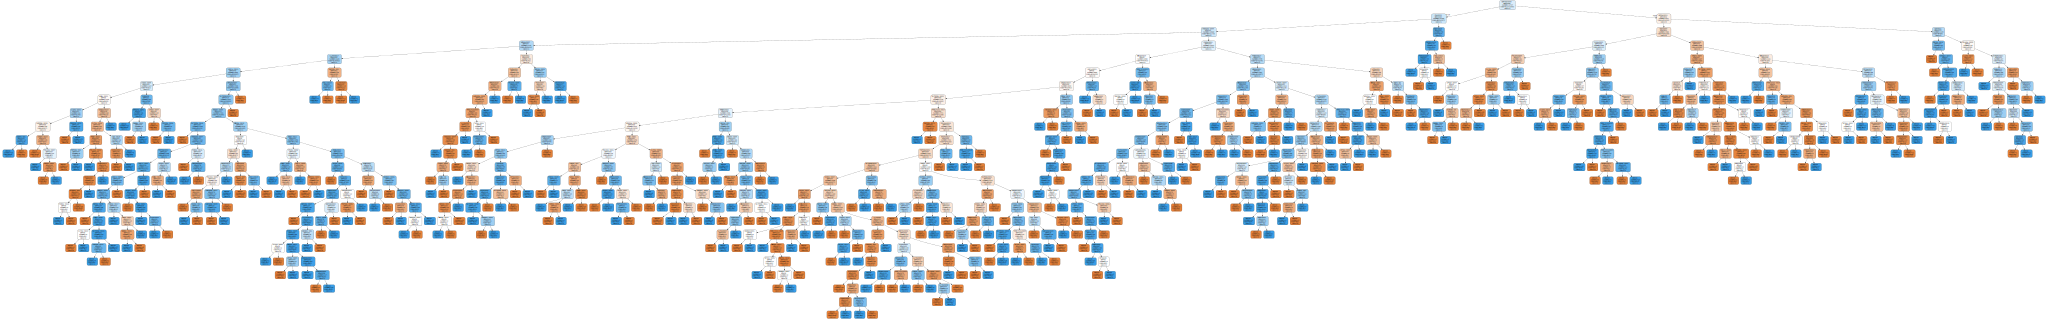

In [ ]:
graph

## Feature importances
* avg feature importances over each model 970 days walk forward C.V

In [ ]:
np.array(fea_imp).mean(axis=0)

array([0.02933387, 0.02858578, 0.03028732, 0.02558308, 0.03251478,
       0.02047643, 0.02207134, 0.02709211, 0.02686434, 0.03164849,
       0.03315936, 0.03213148, 0.02055258, 0.02929198, 0.02531802,
       0.0307978 , 0.02966016, 0.02552702, 0.02073384, 0.02471939,
       0.02902773, 0.024365  , 0.02316908, 0.02886652, 0.02690695,
       0.02755796, 0.02159001, 0.02213624, 0.03058539, 0.02627878,
       0.02214123, 0.02626954, 0.02336136, 0.02159762, 0.02146411,
       0.01781475, 0.01673745, 0.01793715, 0.02584397])

In [ ]:
import seaborn as sns
sns.set_style('darkgrid')

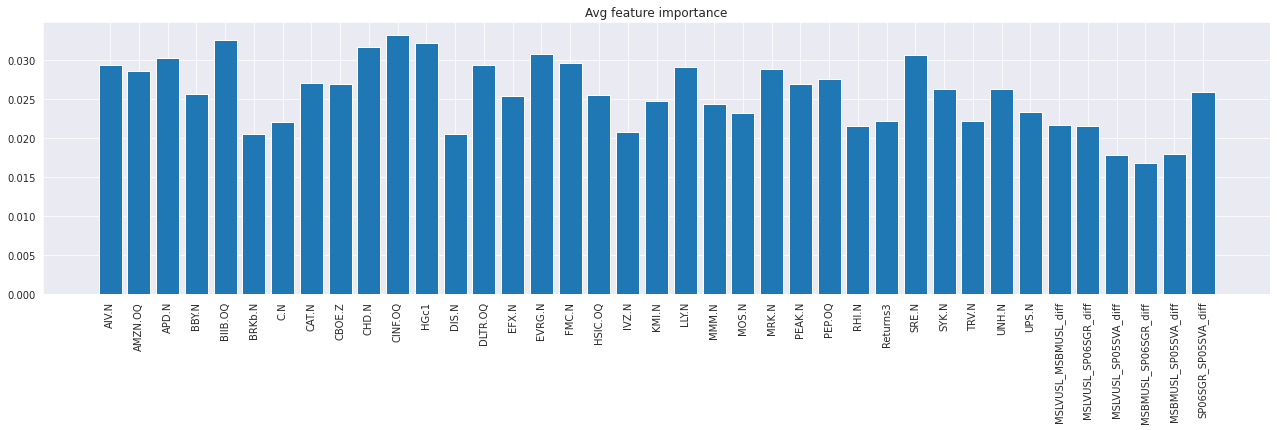

In [ ]:
plt.figure(1,figsize=(22,5))
plt.bar(x=X_train.columns.tolist(),height=np.array(fea_imp).mean(axis=0))
plt.xticks(np.arange(X_train.shape[1]),X_train.columns.tolist(),rotation=90);
plt.title('Avg feature importance');

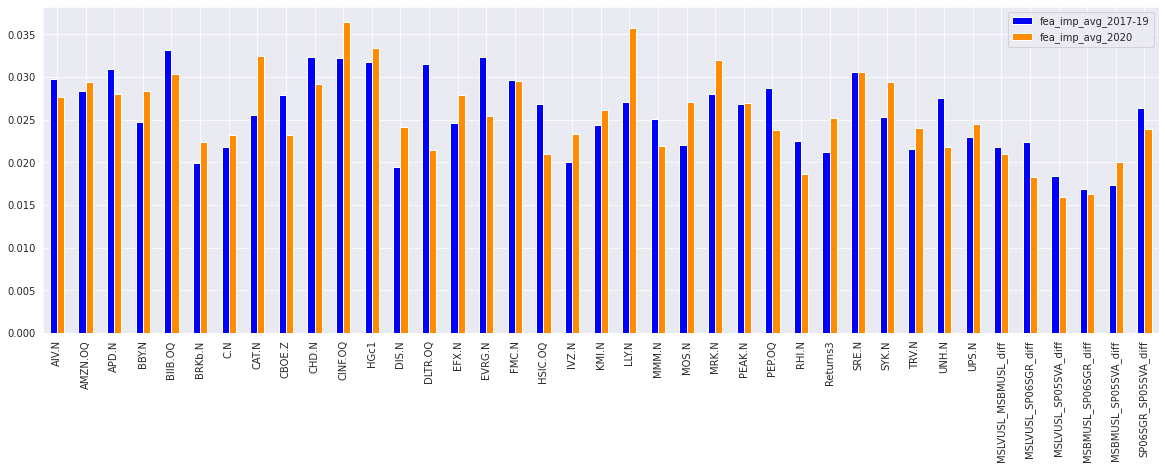

In [ ]:
fea_temp_df = pd.DataFrame({'fea_imp_avg_2017-19':np.array(fea_imp[:753]).mean(axis=0),
                            'fea_imp_avg_2020':np.array(fea_imp[753:]).mean(axis=0)},index=X_train.columns.tolist())
fea_temp_df.plot.bar(rot=1, color={"fea_imp_avg_2017-19": "blue", "fea_imp_avg_2020": "darkorange"},figsize=(20,6))
plt.xticks(np.arange(X_train.shape[1]),X_train.columns.tolist(),rotation=90);

### As can be seen here from feature importance of some companies have sort up in 2020:
* **LLY.N** : *Eli Lilly and Company is an **American pharmaceutical company** headquartered in Indianapolis*
* **FMC.N** : *FMC Corporation is an **American chemical manufacturing company** headquartered in Philadelphia, Pennsylvania, which originated as an insecticide producer and later diversified into other industries* 
* **BIIB.OQ** : *Biogen Inc. is an **American multinational biotechnology company** based in Cambridge*

***

* **CAT.N** : *Caterpillar Inc. is an American Fortune 100 corporation which designs, develops, engineers, manufactures, markets, and sells machinery, engines, financial products, and insurance to customers via a worldwide dealer network. It is the world's largest **construction equipment manufacturer**.*

## How each feature importance changed over course of 970 days

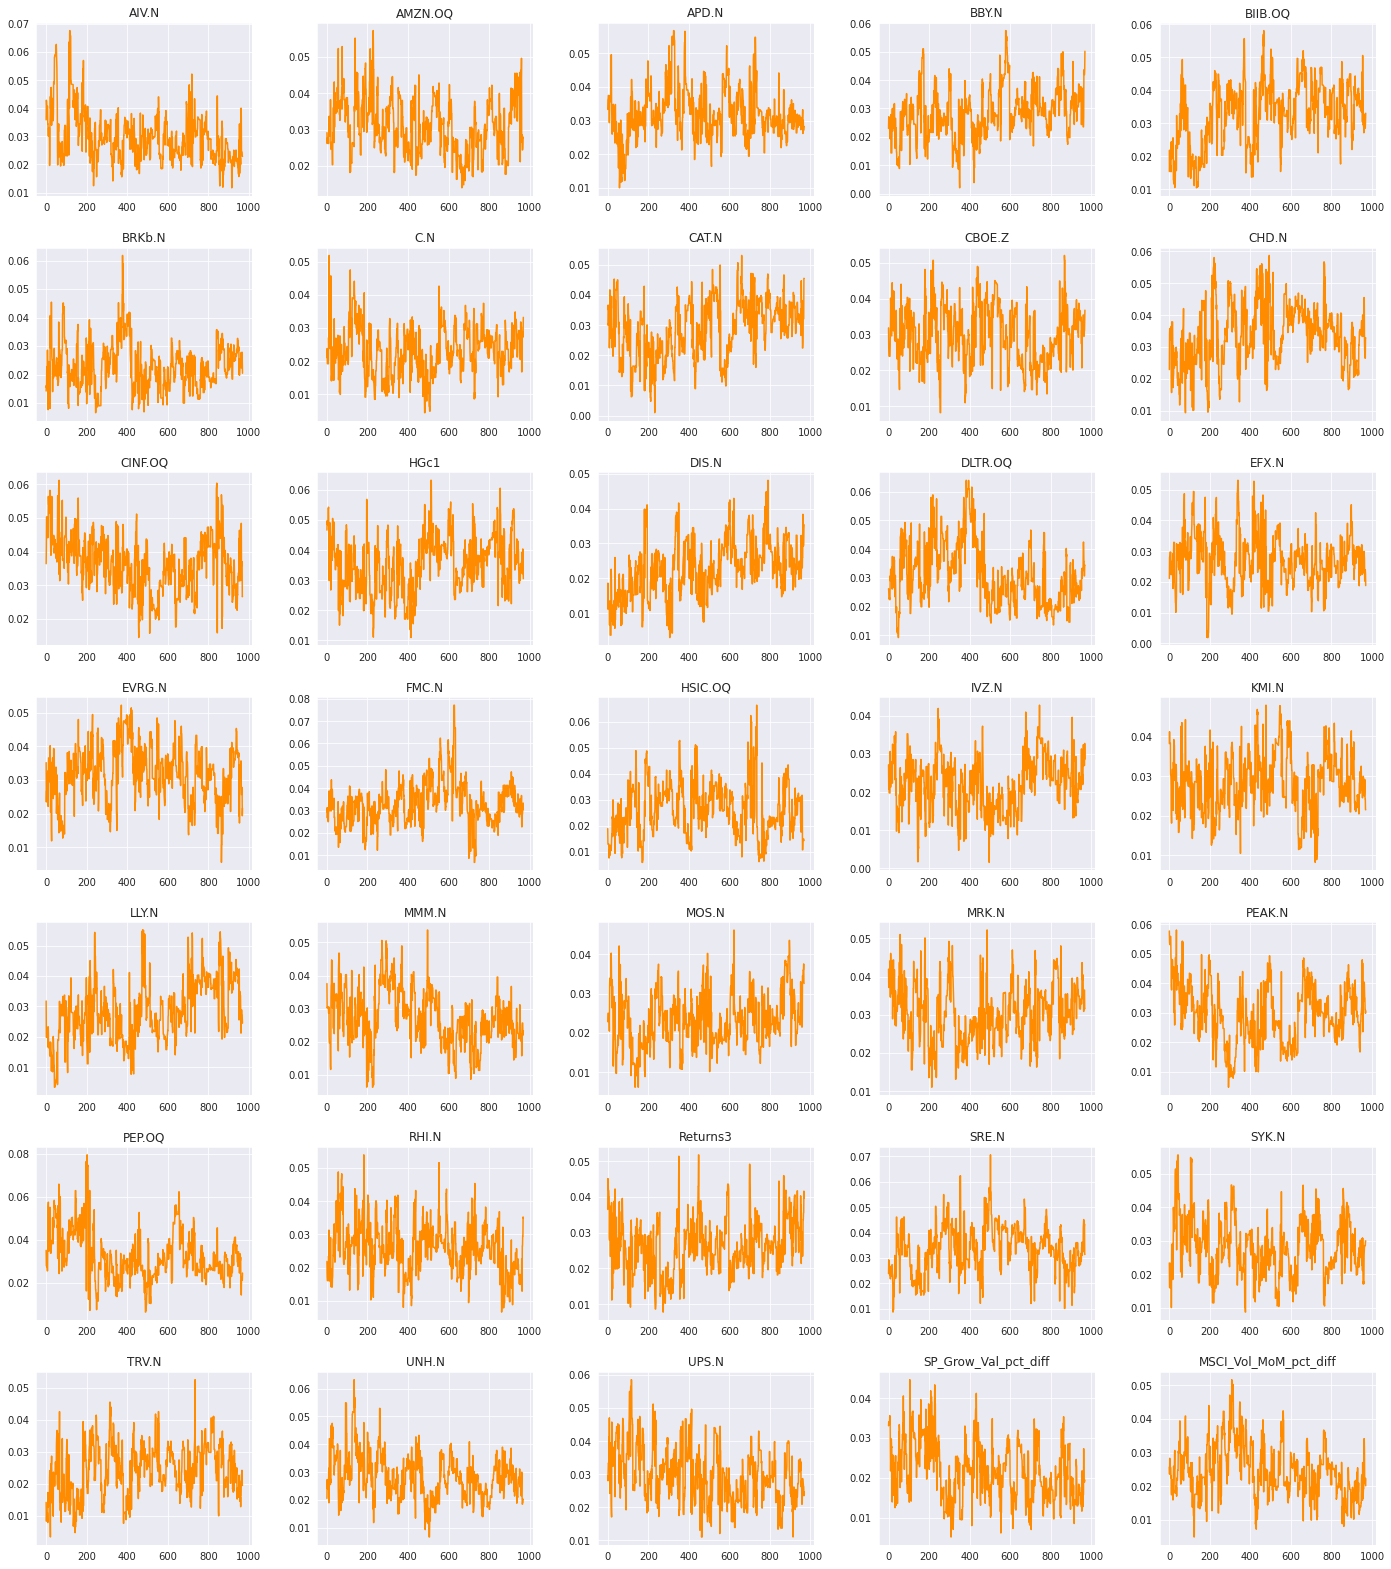

In [ ]:
fig = plt.figure(1,figsize=(24,28))
columns = 5
rows = 7
fea_num = 0
fea_cccc = X_train.columns.tolist()
for i in range(rows*columns):
    fig.add_subplot(rows, columns, i+1)
    plt.plot(np.array(fea_imp)[:,min(fea_num,34)],color='darkorange')
    plt.title(fea_cccc[min(fea_num,34)])
    fea_num+=1
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

In [ ]:
#fea_results = np.array([dt_dates,fea_imp])

In [ ]:
#np.save('feature_imp_dates',fea_results)

### Last Model parameters of 970th

## Sanity check

In [ ]:
mydftrn.shape

(2727, 34)

In [ ]:
mydftrn

,AIV.N,AMZN.OQ,APD.N,BBY.N,BIIB.OQ,BRKb.N,C.N,CAT.N,CBOE.Z,CHD.N,CINF.OQ,HGc1,DIS.N,DLTR.OQ,EFX.N,EVRG.N,FMC.N,HSIC.OQ,IVZ.N,KMI.N,LLY.N,MMM.N,MOS.N,MRK.N,PEAK.N,PEP.OQ,RHI.N,Returns3,SRE.N,SYK.N,TRV.N,UNH.N,UPS.N,tclass
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-09-02,0.019726,0.020530,0.032641,0.024495,-0.001085,0.003461,0.008447,0.005575,0.002313,0.013417,0.003987,0.003320,0.011937,0.020675,0.006285,-0.001639,0.010341,0.002471,0.014737,0.014737,0.003216,0.010616,-0.002052,-0.007580,0.007403,0.001233,0.015908,0.039259,0.018099,0.024194,-0.001789,0.008285,0.014050,1
2017-11-20,0.001358,-0.003160,-0.000062,0.009314,-0.014364,0.003148,0.010094,0.005730,0.023609,-0.001564,-0.000408,0.007832,-0.006671,0.026424,-0.004130,-0.000361,-0.002905,-0.023437,0.013722,0.002939,0.003499,0.009287,0.003923,-0.019928,0.000000,0.002006,0.000000,0.006831,-0.005941,-0.004183,-0.001155,0.001667,0.002302,1
2017-10-18,-0.001131,-0.012020,-0.001759,0.014822,0.000320,0.002455,0.012883,0.005745,0.000548,-0.006080,0.000922,-0.007847,-0.001118,-0.000656,0.018788,-0.000190,-0.003813,-0.001942,0.016579,-0.005353,-0.003835,0.002388,0.004748,0.004587,-0.000378,-0.002139,0.022254,0.003169,-0.008681,-0.001008,0.010649,0.006572,0.003994,1
2012-05-25,-0.001499,-0.010918,-0.006339,0.018597,-0.000684,-0.006892,-0.007127,-0.016189,-0.005908,-0.003535,0.000561,0.003057,0.001350,0.004818,0.003959,0.011420,-0.011349,0.006398,-0.002778,0.009654,-0.001215,-0.002353,-0.005950,-0.001330,-0.007750,-0.002471,-0.006265,0.000904,0.004684,0.002514,-0.009337,-0.001779,-0.003192,1
2019-11-11,0.002447,-0.007968,0.004960,-0.007807,0.003035,-0.002079,-0.006831,-0.001080,0.001915,-0.000740,0.004048,-0.007092,-0.008843,-0.012868,0.007316,-0.006977,0.013408,-0.021913,-0.010101,-0.004493,-0.006430,-0.017557,0.005766,-0.003709,-0.008311,-0.005558,0.001381,0.003325,0.001478,-0.006807,0.001876,-0.011208,-0.009332,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-08,0.000205,-0.016198,-0.001925,0.001529,0.020698,-0.004015,-0.012737,-0.001398,-0.003684,0.012144,-0.003321,-0.006716,0.005047,-0.006511,0.002627,0.007981,0.003800,-0.053142,-0.020142,0.003341,0.017872,-0.000100,-0.006688,0.009112,-0.004144,-0.000663,0.005392,-0.010892,-0.000847,0.010567,-0.007652,-0.026394,0.001482,1
2020-10-01,0.043592,0.023035,-0.010710,0.025159,0.006663,-0.004320,0.007655,-0.016359,0.009688,-0.006509,-0.018982,-0.051656,-0.006206,0.005802,0.007075,0.000000,-0.025682,-0.014631,-0.014023,-0.007299,-0.025199,-0.008678,-0.026273,-0.015793,0.032781,0.015873,-0.007556,0.008712,0.006506,0.001440,-0.003512,0.004170,0.006121,0
2017-03-20,-0.002715,0.005467,-0.006020,-0.004154,-0.004673,-0.004340,-0.012920,0.026800,-0.000745,0.001796,-0.012769,-0.009712,0.008500,-0.018494,-0.003086,0.001277,0.002778,0.000934,-0.004483,-0.004229,0.001191,0.003379,0.002743,0.003286,0.001660,-0.002155,-0.009487,-0.004943,-0.003341,-0.000528,-0.006334,-0.010018,-0.009524,0


In [ ]:
mydftst

,AIV.N,AMZN.OQ,APD.N,BBY.N,BIIB.OQ,BRKb.N,C.N,CAT.N,CBOE.Z,CHD.N,CINF.OQ,HGc1,DIS.N,DLTR.OQ,EFX.N,EVRG.N,FMC.N,HSIC.OQ,IVZ.N,KMI.N,LLY.N,MMM.N,MOS.N,MRK.N,PEAK.N,PEP.OQ,RHI.N,Returns3,SRE.N,SYK.N,TRV.N,UNH.N,UPS.N,tclass
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-06,-0.025989,-0.0032,0.011142,0.0,0.0,0.006749,-0.008358,-0.011037,0.019266,0.00522,-0.004024,0.014164,0.003938,0.004522,-0.010419,-0.002718,-0.004398,0.001624,-0.038115,-0.035294,-0.019104,-0.001103,-0.016308,-0.001243,-0.020237,0.00239,-0.009192,0.041636,-0.017164,0.013485,-0.004,-0.019582,0.02519,1


In [ ]:
mydf

,AIV.N,AMZN.OQ,APD.N,BBY.N,BIIB.OQ,BRKb.N,C.N,CAT.N,CBOE.Z,CHD.N,CINF.OQ,HGc1,DIS.N,DLTR.OQ,EFX.N,EVRG.N,FMC.N,HSIC.OQ,IVZ.N,KMI.N,LLY.N,MMM.N,MOS.N,MRK.N,PEAK.N,PEP.OQ,RHI.N,Returns3,SRE.N,SYK.N,TRV.N,UNH.N,UPS.N,tclass
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-08,-0.023177,0.027077,0.006395,-0.039239,0.020568,-0.000286,-0.016438,0.011228,0.011228,-0.002162,-0.003375,-0.004676,0.001571,-0.013795,0.000313,0.008825,-0.008852,0.005964,-0.005640,-0.005640,-0.007655,0.007046,0.014294,-0.000530,0.006619,-0.003280,-0.000684,0.007444,-0.000557,0.003077,-0.001439,-0.009391,0.048075,1
2010-01-11,0.007717,-0.024056,0.018328,-0.017038,-0.003326,0.000900,0.011142,0.062811,0.062811,-0.004334,0.007524,0.008662,-0.016311,-0.005473,-0.009393,0.015193,-0.027338,0.032988,0.030977,0.030977,0.013714,-0.004032,-0.005847,0.003979,0.011176,-0.001152,0.004793,0.008653,0.014495,-0.003067,-0.000412,0.006728,0.044042,0
2010-01-12,-0.025898,-0.022700,-0.012719,0.000765,-0.012061,-0.007486,-0.030303,-0.029471,-0.029471,0.025448,-0.001867,-0.036390,-0.017219,0.011826,-0.006005,-0.004989,-0.003489,-0.013997,-0.014388,-0.014388,-0.003382,0.000834,-0.057608,-0.007926,-0.016905,0.014003,-0.035434,-0.004791,-0.003480,-0.000724,0.006386,-0.026428,-0.006686,1
2010-01-13,0.027790,0.013820,0.009966,0.011971,0.015587,-0.000030,-0.005682,0.001446,0.001446,0.013061,0.008979,0.017069,0.015250,-0.004835,0.010175,0.009572,0.003871,0.026386,0.003864,0.003864,0.013857,-0.003212,0.000800,0.036751,0.007606,0.008123,0.003886,0.000611,-0.009743,0.004709,0.003480,0.015289,-0.005288,1
2010-01-14,-0.011170,-0.013632,-0.012394,-0.009565,0.005179,-0.000606,0.002857,-0.005615,-0.005615,0.007736,0.002225,0.007872,-0.008629,-0.003036,0.006610,0.001354,-0.014875,-0.004790,-0.016253,-0.016253,0.004184,-0.003342,-0.027183,0.027228,-0.002953,0.012087,0.014075,0.001290,-0.005012,0.009915,0.005304,0.023970,0.002094,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-02,0.006897,-0.010431,0.037829,0.037382,-0.012219,0.011937,0.019073,0.039605,0.025587,-0.005544,0.020922,0.009173,-0.009237,0.008857,0.038433,0.020109,0.040977,-0.021390,0.028223,-0.000840,0.008968,0.018630,0.057297,0.019944,0.047460,0.013955,0.018150,0.011987,0.018028,0.003812,0.026593,0.022810,0.015531,1
2020-11-03,0.032207,0.014621,0.008197,0.026789,-0.007952,0.011355,0.031272,0.027072,0.040422,0.012514,0.020354,0.002435,0.032382,0.027766,0.057455,0.011898,-0.021505,-0.029090,0.037092,0.008410,-0.004938,0.015773,-0.121166,0.002738,0.009912,0.013984,0.018989,0.017839,0.011597,0.027024,0.019529,0.029638,0.024632,1
2020-11-04,-0.010386,0.063230,0.000865,0.008753,0.439739,-0.002226,-0.033310,-0.074304,0.002997,0.008652,-0.018999,0.003562,0.008466,0.017085,0.013000,-0.021236,0.002102,-0.007780,-0.016452,-0.013344,0.134448,-0.032324,-0.025596,0.048102,-0.000351,0.005984,-0.027191,0.053053,-0.005190,-0.002545,-0.023271,0.103345,-0.005505,1


## Saving predictions

In [ ]:
res = np.array([y_true,preds_temp,dt_dates])

In [ ]:
np.save('results_tar_pred_date',res)

In [ ]:
pred_sv  = np.array(preds_temp)
name = 'preds_'+str('dt')
np.save(name,pred_sv)

In [ ]:
np.array(preds_temp)

array([1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,

## decision tree on all 970 Creating dataframe for analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
all_prd = df[['Date', 'Index_High', 'Index_Close', 'Index_Low', 'Index_Open','ISPC_High','ISPC_Low','ISPC_Open','ISPC_Close']].copy()

In [ ]:
all_prd = all_prd[all_prd['Date'].isin(dt_dates)];

In [ ]:
all_prd['prediction'] =  preds_temp

In [ ]:
all_prd.isna().sum()

Date           0
Index_High     0
Index_Close    0
Index_Low      0
Index_Open     0
ISPC_High      0
ISPC_Low       0
ISPC_Open      0
ISPC_Close     0
prediction     0
dtype: int64

In [ ]:
all_prd['prediction'][:5]

1829   -1
1830    1
1831   -1
1832    1
1833    1
Name: prediction, dtype: int64

In [ ]:
#all_prd['prediction'] = all_prd['prediction'].apply(lambda x:-1 if x<=0 else x)

In [ ]:
num_cols = [ 'Index_High', 'Index_Close', 'Index_Low', 'Index_Open',
       'ISPC_High', 'ISPC_Low', 'ISPC_Open', 'ISPC_Close', 'prediction']
for c in num_cols:
    all_prd[c] = pd.to_numeric(all_prd[c],errors='coerce')

In [ ]:
all_prd['y_true'] = y_true
all_prd['y_preds'] = preds_temp

In [ ]:
print(all_prd.shape)
print(all_prd.columns)
#print(all_prd[["Date","y_true","y_preds"]][-252:].to_string())

(970, 10)
Index(['Date', 'Index_High', 'Index_Close', 'Index_Low', 'Index_Open',
       'ISPC_High', 'ISPC_Low', 'ISPC_Open', 'ISPC_Close', 'prediction'],
      dtype='object')


In [ ]:
all_prd.to_csv('dt_preds_HOCL_dt_970_without_embargo.csv',index=False)

## Model Performance with stop loss

In [ ]:
stop_loss = 0.75/100

In [ ]:
signals = all_prd['prediction'].values
high = all_prd['Index_High'].values
low = all_prd['Index_Low'].values
close = all_prd['Index_Close'].values
open = all_prd['Index_Open'].values

In [ ]:
signals

array([-1,  1, -1,  1,  1,  1, -1, -1,  1, -1,  1, -1, -1,  1,  1, -1, -1,
        1,  1,  1,  1, -1,  1,  1, -1, -1, -1,  1,  1,  1, -1,  1, -1, -1,
       -1, -1, -1, -1,  1, -1,  1, -1, -1, -1,  1,  1, -1, -1, -1, -1, -1,
        1,  1,  1, -1, -1,  1,  1, -1, -1, -1,  1,  1, -1,  1, -1,  1, -1,
        1, -1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,
        1, -1,  1,  1,  1,  1,  1,  1, -1, -1, -1,  1, -1, -1,  1, -1, -1,
        1, -1,  1,  1, -1,  1, -1,  1, -1, -1,  1,  1, -1, -1,  1, -1, -1,
        1, -1, -1, -1,  1,  1,  1,  1, -1, -1,  1, -1, -1, -1,  1,  1,  1,
       -1,  1,  1, -1,  1, -1,  1, -1,  1,  1,  1,  1, -1,  1, -1,  1,  1,
       -1, -1,  1, -1, -1, -1, -1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,
       -1, -1,  1,  1, -1, -1,  1,  1, -1, -1, -1,  1,  1, -1, -1, -1,  1,
       -1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1, -1, -1,  1, -1, -1,  1,
       -1,  1,  1,  1,  1,  1, -1, -1, -1, -1,  1,  1, -1,  1, -1, -1, -1,
       -1,  1, -1,  1, -1

In [ ]:
ret = [(close[x+1]-close[x])*signals[x] for x in range(len(close)-1)]

In [ ]:
def LONG(close,low,signals,open):
    long = []
    for x in range(len(close)-1):
        stop_loss = 0.75/100 # stop loss
        if signals[x]==1 and ((close[x]-low[x+1]) > stop_loss*close[x]):
            ans = min(-stop_loss*close[x],open[x+1]-close[x])
            long.append(ans)
        else:
            ans = (close[x+1]-close[x])*signals[x]
            long.append(ans)
    return long

# 
def SHORT(close,low,signals,open):
    short = []
    stop_loss = 0.75/100 # stop loss
    for x in range(len(close)-1):
        if signals[x]==-1 and ((high[x+1]-close[x]) > stop_loss*close[x]):
            ans = min(-stop_loss*close[x], close[x]-open[x+1])
            short.append(ans)
        else:
            ans = (close[x+1]-close[x])*signals[x]
            short.append(ans)
    return short



In [ ]:
longg = LONG(close,low,signals,open)
short = SHORT(close,low,signals,open)

### returns with stoploss

In [ ]:
def ret_with_sl(longg,short,signals):
    res = []
    for x in range(len(signals)-1):
        if signals[x]==1:
            res.append(longg[x])
        else:
            res.append(short[x])
    return res

In [ ]:
return_with_sl = ret_with_sl(longg,short,signals)

### pct_change in model,model_sl,s&p500

In [ ]:
pct_chng_sp500 = [(close[x+1]-close[x])/close[x]*100 for x in range(len(close)-1)]
pct_chng_model_sl = [(return_with_sl[x]/close[x])*100 for x in range(len(return_with_sl))]
pct_chng_model = [(ret[x]/close[x])*100 for x in range(len(ret))]

* **noramalize return**

In [ ]:
def norm_ret(val):
    nmrsl = [100]
    for x in range(1,len(val)+1):
        ans = nmrsl[x-1]+val[x-1]*0.01*nmrsl[x-1]
        nmrsl.append(ans)
    return nmrsl

In [ ]:
norm_model_return_sl = norm_ret(pct_chng_model_sl)

In [ ]:
norm_sp500_return = norm_ret(pct_chng_sp500)

In [ ]:
norm_model_ret = norm_ret(pct_chng_model)

### Ploting model performance

In [ ]:
import plotly.graph_objs as go
import math

In [ ]:
ann_ret= np.mean(pct_chng_model_sl)*252
dvol = np.std(pct_chng_model_sl)
ann_vol = math.sqrt(252)*dvol
sharpe_ratio = ann_ret/ann_vol;
x = all_prd.Date.tolist()[:]
trace1 = go.Scatter(x=x, y=norm_sp500_return, 
                    mode='lines', 
                    line=dict(color='darkorange', width=2),
                    name='SP500'
                   )

trace2 = go.Scatter(x=x, y=norm_model_return_sl, 
                    mode='lines', 
                    line=dict(color='navy', width=2),
                    name = 'Model_with_stoploss',
                    showlegend=True)
trace3 = go.Scatter(x=x, y=norm_model_ret, 
                    mode='lines', 
                    line=dict(color='green', width=2),
                    name = 'Model',
                    showlegend=True)

layout = go.Layout(title='Equity Progression',
                   xaxis=dict(title='Dates'),
                   yaxis=dict(title='Normalized Return'))

fig = go.Figure(data=[trace1, trace2,trace3], layout=layout)
fig.show()

In [ ]:
np.prod(1+np.array(pct_chng_model_sl)/100)

3.685998849125629

### Backtesting through backtesting library bt

In [ ]:
import bt
import seaborn as sns

In [ ]:
data_10_19 = all_prd.copy()
data_10_19.Date = pd.to_datetime(data_10_19.Date)

In [ ]:
data_10_19.set_index('Date',inplace=True)

### S&P500 Index

In [ ]:
### Loading predicitons to a csv file
temp_xgb_more_features_complete_M1B = np.array([signals]).flatten()
np.savetxt("preds_M1B.csv", temp_xgb_more_features_complete_M1B)

In [ ]:
signals[:10]

array([-1,  1, -1,  1,  1,  1, -1, -1,  1, -1])

In [ ]:
choice = 0             #Select 0 for index 1 for futures close
clos = ['Index_Close',"ISPC_Close"];clo = clos[choice];  
name = ['S&P500','S&P500_futures'];nm = name[choice];
start1 = data_10_19.index.searchsorted(datetime(2017, 1, 3))
end1 = data_10_19.index.searchsorted(datetime(2020, 11, 9))
bk_data = data_10_19[start1:end1+1].copy()
bk_data.reset_index(inplace=True)
bk_data = bk_data.loc[:,('Date',clo)].copy()
#print(bk_data)
temp_xgb_more_features_complete_preds_M2 = loadtxt("preds_M1B.csv")
bk_data['Predictions'] = pd.Series(temp_xgb_more_features_complete_preds_M2)
bk_data.set_index('Date',inplace=True)
bk_data[clo] = pd.to_numeric(bk_data[clo])
#print(bk_data)
bk_df_ = bk_data[[clo]].copy()
bk_df_.columns = ['SP500']
bk_sig = bk_data[['Predictions']].copy()
bk_sig.columns = ['SP500']
tw = bk_sig.copy()
#print(bk_sig)
    
tw[bk_sig == 1.0] = 1.0
tw[bk_sig == 0.0] = 0.0
tw[bk_sig == -1.0] = -1.0
    
#print(tw)
s1 = bt.Strategy(
        "Model",
        [
            bt.algos.RunDaily(),
            bt.algos.WeighTarget(tw),  # Triggers weights for long/short strategy
            bt.algos.Rebalance(),
        ],
    )
s2 = bt.Strategy(
        nm,
        [
            bt.algos.RunDaily(),
            bt.algos.SelectAll(),
            bt.algos.WeighEqually(),
            bt.algos.Rebalance(),
        ],
    )
test = bt.Backtest(s1, bk_df_)
test_sp500 = bt.Backtest(s2, bk_df_)
res1 = test
res2 = test_sp500
a = bt.run(res1, res2)

Model
0% [############################# ] 100% | ETA: 00:00:00S&P500


/usr/local/lib/python3.6/dist-packages/ffn/core.py:2056: RuntimeWarning:

divide by zero encountered in true_divide



0% [############################# ] 100% | ETA: 00:00:00

/usr/local/lib/python3.6/dist-packages/ffn/core.py:2056: RuntimeWarning:

divide by zero encountered in true_divide



Stat                 Model       S&P500
-------------------  ----------  ----------
Start                2017-01-02  2017-01-02
End                  2020-11-06  2020-11-06
Risk-free rate       0.00%       0.00%

Total Return         176.52%     55.32%
Daily Sharpe         1.38        0.66
Daily Sortino        2.36        0.96
CAGR                 30.29%      12.14%
Max Drawdown         -22.02%     -33.88%
Calmar Ratio         1.38        0.36

MTD                  -3.32%      7.31%
3m                   -15.86%     4.78%
6m                   -9.89%      23.17%
YTD                  50.24%      8.61%
1Y                   54.52%      14.04%
3Y (ann.)            39.30%      10.62%
5Y (ann.)            30.29%      12.14%
10Y (ann.)           30.29%      12.14%
Since Incep. (ann.)  30.29%      12.14%

Daily Sharpe         1.38        0.66
Daily Sortino        2.36        0.96
Daily Mean (ann.)    28.56%      13.60%
Daily Vol (ann.)     20.70%      20.72%
Daily Skew           0.97        -0.73

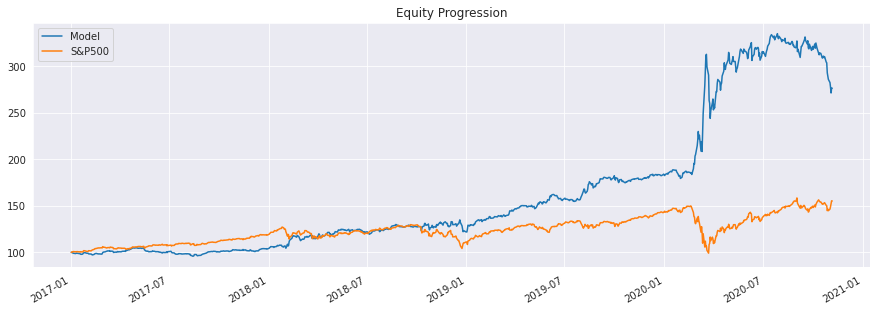

In [ ]:
a_res = a.prices
a.display()
a.plot();

In [ ]:
all_prd

,Date,Index_High,Index_Close,Index_Low,Index_Open,ISPC_High,ISPC_Low,ISPC_Open,ISPC_Close,prediction,y_true,y_preds
1829,2017-01-03,2263.88,2257.83,2245.13,2251.57,2259.0,2240.0,2252.0,2252.6,1,1,1
1830,2017-01-04,2272.82,2270.75,2261.60,2261.60,2267.0,2256.5,2256.8,2264.3,1,-1,1
1831,2017-01-05,2271.50,2269.00,2260.45,2268.18,2265.0,2254.0,2257.7,2264.3,-1,1,-1
1832,2017-01-06,2282.10,2276.98,2264.06,2271.14,2276.5,2258.5,2265.0,2271.5,-1,-1,-1
1833,2017-01-09,2275.49,2268.90,2268.90,2273.59,2269.8,2263.5,2268.2,2265.0,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
2828,2020-11-02,3330.14,3310.24,3279.74,3296.20,3300.5,3300.5,3300.5,3300.5,-1,1,-1
2829,2020-11-03,3389.49,3369.16,3336.25,3336.25,3361.6,3361.6,3361.6,3361.6,1,1,1
2830,2020-11-04,3486.25,3443.44,3405.17,3406.46,3434.9,3434.9,3434.9,3434.9,1,1,1
2831,2020-11-05,3529.05,3510.45,3485.74,3485.74,3504.8,3504.8,3504.8,3504.8,1,-1,1


### S&P500 futures

In [ ]:
choice = 1             #Select 0 for index 1 for futures close
clos = ['Index_Close',"ISPC_Close"];clo = clos[choice];  
name = ['S&P500','S&P500_futures'];nm = name[choice];
start1 = data_10_19.index.searchsorted(datetime(2017, 1, 3))
end1 = data_10_19.index.searchsorted(datetime(2019, 12, 30))
bk_data = data_10_19[start1:end1+1].copy()
bk_data.reset_index(inplace=True)
bk_data = bk_data.loc[:,('Date',clo)].copy()
#print(bk_data)
temp_xgb_more_features_complete_preds_M2 = loadtxt("preds_M1B.csv")
bk_data['Predictions'] = pd.Series(temp_xgb_more_features_complete_preds_M2)
bk_data.set_index('Date',inplace=True)
bk_data[clo] = pd.to_numeric(bk_data[clo])
#print(bk_data)
bk_df_ = bk_data[[clo]].copy()
bk_df_.columns = ['SP500']
bk_sig = bk_data[['Predictions']].copy()
bk_sig.columns = ['SP500']
tw = bk_sig.copy()
#print(bk_sig)
    
tw[bk_sig == 1.0] = 1.0
tw[bk_sig == 0.0] = 0.0
tw[bk_sig == -1.0] = -1.0
    
#print(tw)
s1 = bt.Strategy(
        "Model",
        [
            bt.algos.RunDaily(),
            bt.algos.WeighTarget(tw),  # Triggers weights for long/short strategy
            bt.algos.Rebalance(),
        ],
    )
s2 = bt.Strategy(
        nm,
        [
            bt.algos.RunDaily(),
            bt.algos.SelectAll(),
            bt.algos.WeighEqually(),
            bt.algos.Rebalance(),
        ],
    )
test = bt.Backtest(s1, bk_df_)
test_sp500 = bt.Backtest(s2, bk_df_)
res1 = test
res2 = test_sp500
a1 = bt.run(res1, res2)

Model
0% [############################# ] 100% | ETA: 00:00:00S&P500_futures


/usr/local/lib/python3.6/dist-packages/ffn/core.py:2056: RuntimeWarning:

divide by zero encountered in true_divide



0% [############################# ] 100% | ETA: 00:00:00

/usr/local/lib/python3.6/dist-packages/ffn/core.py:2056: RuntimeWarning:

divide by zero encountered in true_divide



Stat                 Model       S&P500_futures
-------------------  ----------  ----------------
Start                2017-01-02  2017-01-02
End                  2019-12-30  2019-12-30
Risk-free rate       0.00%       0.00%

Total Return         124.85%     43.01%
Daily Sharpe         2.15        0.98
Daily Sortino        4.12        1.46
CAGR                 31.13%      12.71%
Max Drawdown         -7.48%      -20.30%
Calmar Ratio         4.16        0.63

MTD                  1.30%       2.53%
3m                   -2.18%      8.21%
6m                   21.40%      9.47%
YTD                  41.10%      28.61%
1Y                   40.01%      29.61%
3Y (ann.)            31.13%      12.71%
5Y (ann.)            -           -
10Y (ann.)           -           -
Since Incep. (ann.)  31.13%      12.71%

Daily Sharpe         2.15        0.98
Daily Sortino        4.12        1.46
Daily Mean (ann.)    27.97%      12.83%
Daily Vol (ann.)     13.03%      13.10%
Daily Skew           0.91        -

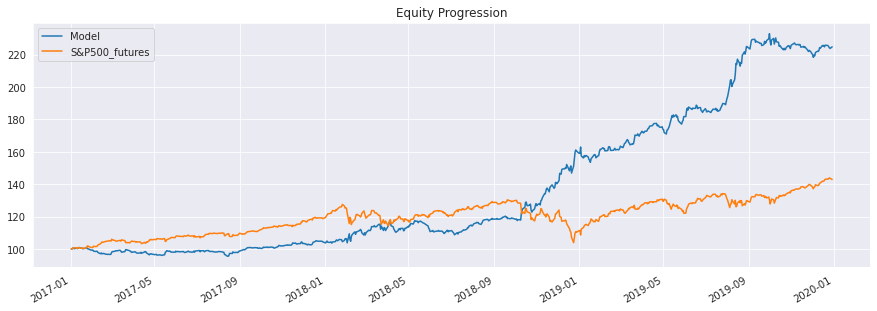

In [ ]:
a1_res = a.prices
a1.display()
a1.plot();

In [ ]:
a.prices["Model"].pct_change()[:10]

2017-01-02         NaN
2017-01-03    0.000000
2017-01-04    0.005711
2017-01-05   -0.000769
2017-01-06   -0.003518
2017-01-09    0.003550
2017-01-10    0.000000
2017-01-11   -0.002830
2017-01-12    0.002148
2017-01-13    0.001849
Name: Model, dtype: float64

In [ ]:
a.prices["S&P500"].pct_change()[:10]

2017-01-02         NaN
2017-01-03    0.000000
2017-01-04    0.005711
2017-01-05   -0.000769
2017-01-06    0.003510
2017-01-09   -0.003541
2017-01-10    0.000000
2017-01-11    0.002824
2017-01-12   -0.002140
2017-01-13    0.001846
Name: S&P500, dtype: float64